# An algorithm for a Dog Identification App 

---
This project will make the first steps towards developing an algorithm that could be used as part of a mobile or web app. The code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays a sample output.

![Sample Dog Output](images/sample_dog_output.png)

---
<a id='step0'></a>


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Detect Humans

OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is used to detect human faces in images.  A pre-trained face detector - haarcascade_frontalface_alt, from [github](https://github.com/opencv/opencv/tree/master/data/haarcascades) is stored in the `haarcascades` directory.

Number of faces detected: 1


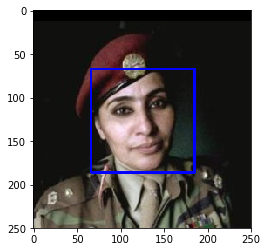

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### A Human Face Detector

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

This procedure is used to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, named `face_detector`, takes a string-valued file path to an image as input and is shown below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

humans_human_files = [face_detector(file) for file in human_files_short]
humans_dog_files = [face_detector(file) for file in dog_files_short]

hhf = np.sum(humans_human_files)/len(humans_human_files)*100
print ('Percentage of the first 100 images in human_files that have a detected human face = ', hhf)
hdf = np.sum(humans_dog_files)/len(humans_dog_files)*100
print ('Percentage of the first 100 images in dog_files that have a detected human face = ', hdf)


Percentage of the first 100 images in human_files that have a detected human face =  100.0
Percentage of the first 100 images in dog_files that have a detected human face =  11.0


---
<a id='step2'></a>
## Detect Dogs

A pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model is used to detect dogs in images.  The ResNet-50 model is downloaded, along with weights that have been trained on [ImageNet](http://www.image-net.org/).  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

# takes a file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  

The model can be used to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, an integer is obtained corresponding to the model's predicted object class, which we can be identified with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

# returns prediction vector for image located at img_path
def ResNet50_predict_labels(img_path):
    # RGB image is reordered to BGR and normalization is performed
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

In the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, the `ResNet50_predict_labels` function above should return a value between 151 and 268 (inclusive).

The `dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In [11]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dogs_human_files = [dog_detector(file) for file in human_files_short]
dogs_dog_files = [dog_detector(file) for file in dog_files_short]

dhf = np.sum(dogs_human_files)/len(dogs_human_files)*100
print ('Percentage of the first 100 images in human_files that have a detected dog face = ', dhf)
ddf = np.sum(dogs_dog_files)/len(dogs_dog_files)*100
print ('Percentage of the first 100 images in dog_files that have a detected dog face = ', ddf)

Percentage of the first 100 images in human_files that have a detected dog face =  0.0
Percentage of the first 100 images in dog_files that have a detected dog face =  100.0


---
<a id='step3'></a>
## Create a CNN to Classify Dog Breeds (from Scratch)

Some challenges include:  
- Inter-class variation:   
  For example: Brittany and a Welsh Springer Spaniel  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

- Intra-class variation:  
  For example: Labradors . 
  
Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

### Pre-process the Data

The images are rescaled by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 100.14it/s]


### Model Architecture

Multiple convolutional layers of various sizes were used.  
The model started with a convolutional layer with 32 filters, kernel size of 3 and stride of 2. 'same' padding was chosen and a relu activation was used. This was followed up with a max pooling layer and dropout was used to avoid overfitting.  
This was repeated two more times, with different sizes so that the model will learn more features.  
The final layer is a dense layer with a softmax activation. The number of nodes here is the number of dog breeds.  
This architecture should work reasonable well, since it has a good number of covolutional layers to learn images and also uses dropout to prevent overfitting.

In [13]:
train_tensors.shape

(6680, 224, 224, 3)

In [34]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
### Define the architecture.
model.add(Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D(pool_size=3, strides=1))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=3, strides=4, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=3, strides=4, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(len(dog_names),activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 4, 4, 128)         73856     
__________

### Compile the Model

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [36]:
from keras.callbacks import ModelCheckpoint  

# Choose the number of epochs to train the model.

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 15s 2ms/step - loss: 4.8773 - acc: 0.0102 - val_loss: 4.8437 - val_acc: 0.0168
Epoch 2/50
6680/6680 [==============================] - 14s 2ms/step - loss: 4.7763 - acc: 0.0204 - val_loss: 4.7308 - val_acc: 0.0251
Epoch 3/50
6680/6680 [==============================] - 14s 2ms/step - loss: 4.6495 - acc: 0.0304 - val_loss: 4.5618 - val_acc: 0.0383
Epoch 4/50
6680/6680 [==============================] - 14s 2ms/step - loss: 4.5103 - acc: 0.0412 - val_loss: 4.4556 - val_acc: 0.0479
Epoch 5/50
6680/6680 [==============================] - 14s 2ms/step - loss: 4.3963 - acc: 0.0501 - val_loss: 4.3401 - val_acc: 0.0599
Epoch 6/50
6680/6680 [==============================] - 14s 2ms/step - loss: 4.2865 - acc: 0.0669 - val_loss: 4.2819 - val_acc: 0.0754
Epoch 7/50
6680/6680 [==============================] - 14s 2ms/step - loss: 4.1895 - acc: 0.0744 - val_loss: 4.2672 - val_acc: 0.0778
Epoch 8/

Epoch 28/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.2787 - acc: 0.2126 - val_loss: 3.8752 - val_acc: 0.1150
Epoch 29/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.2489 - acc: 0.2186 - val_loss: 3.9318 - val_acc: 0.0970
Epoch 30/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.2144 - acc: 0.2229 - val_loss: 4.0298 - val_acc: 0.0958
Epoch 31/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.2113 - acc: 0.2196 - val_loss: 3.9851 - val_acc: 0.0910
Epoch 32/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.1636 - acc: 0.2293 - val_loss: 3.9326 - val_acc: 0.1150
Epoch 33/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.1420 - acc: 0.2418 - val_loss: 3.9353 - val_acc: 0.1066
Epoch 34/50
6680/6680 [==============================] - 14s 2ms/step - loss: 3.1490 - acc: 0.2415 - val_loss: 3.9372 - val_acc: 0.1042
Epoch 35/50
6680/6680 [=========================

### Load the Model with the Best Validation Loss

In [37]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [38]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 12.7990%


---
<a id='step5'></a>
## Create a CNN to Classify Dog Breeds (using Transfer Learning)

The bottleneck features from a pre-trained Inception model are used. They can be found at:  
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features

The files are encoded as:

`DogInceptionV3Data.npz`

### Obtain Bottleneck Features

In [50]:
### Obtain bottleneck features from pre-trained Inception CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### Model Architecture

The Inception model was used.  
First bottleneck features from InceptionV3 were extracted for train, validation and test sets.  
A GlobalAveragePooling layer was added.  
The final layer was a dense layer with a softmax activation was used. The number of nodes here is 133 (the number of dog breeds).  
The accuracy obtained using this was 79.9%.

In [51]:
### Define the architecture.
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [52]:
### Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [53]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 394us/step - loss: 1.1767 - acc: 0.7084 - val_loss: 0.6494 - val_acc: 0.8096
Epoch 2/20
6680/6680 [==============================] - 2s 321us/step - loss: 0.4705 - acc: 0.8566 - val_loss: 0.6316 - val_acc: 0.8359
Epoch 3/20
6680/6680 [==============================] - 2s 311us/step - loss: 0.3715 - acc: 0.8876 - val_loss: 0.6683 - val_acc: 0.8287
Epoch 4/20
6680/6680 [==============================] - 2s 316us/step - loss: 0.2986 - acc: 0.9087 - val_loss: 0.7141 - val_acc: 0.8431
Epoch 5/20
6680/6680 [==============================] - 2s 311us/step - loss: 0.2460 - acc: 0.9222 - val_loss: 0.7280 - val_acc: 0.8299
Epoch 6/20
6680/6680 [==============================] - 2s 312us/step - loss: 0.2034 - acc: 0.9364 - val_loss: 0.7357 - val_acc: 0.8467
Epoch 7/20
6680/6680 [==============================] - 2s 316us/step - loss: 0.1654 - acc: 0.9449 - val_loss: 0.7755 - val_acc: 0.8527
E

### Load the Model with the Best Validation Loss

In [54]:
### Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### Test the Model

In [55]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.9043%


### Predict Dog Breed with the Model

In [62]:
### Function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def detect_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Algorithm

The algorithm below accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, returns the predicted breed.
- if a __human__ is detected in the image, returns the resembling dog breed.
- if __neither__ is detected in the image, output indicates an error.

In [77]:
def dog_breed_predictor(img_path):
    # Load the image
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    
    # Use dog detector and dog_breed_predictor functions to detect dogs and predict their breed
    if dog_detector(img_path):
        print("Hi, dog! Your breed is ", detect_breed(img_path))
    elif face_detector(img_path):
        print("Hi, human! You resemble the dog breed ", detect_breed(img_path))
    else:
        print("Sorry, I don't recognize you!")

---
<a id='step7'></a>
## Test the Algorithm on Sample Images

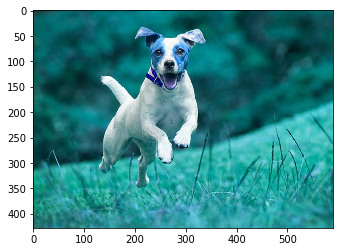

Hi, dog! Your breed is  in/116.Parson_russell_terrier


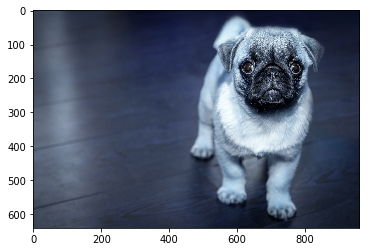

Hi, dog! Your breed is  in/040.Bulldog


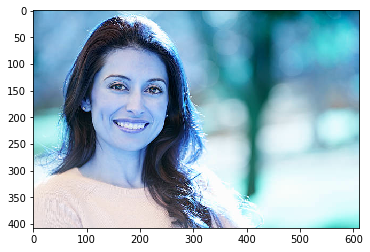

Hi, human! You resemble the dog breed  in/002.Afghan_hound


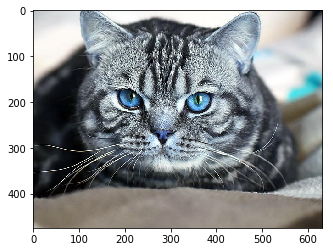

Sorry, I don't recognize you!


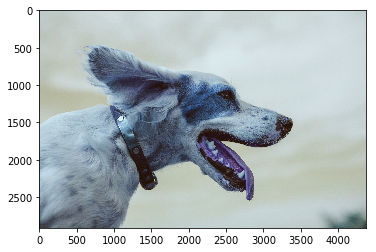

Hi, dog! Your breed is  in/062.English_setter


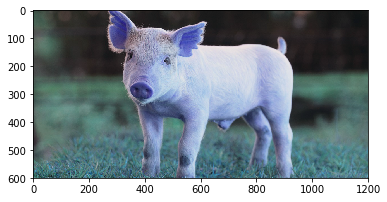

Hi, human! You resemble the dog breed  in/039.Bull_terrier


In [78]:
dog_breed_predictor('test_imgs/d1.jpg')
dog_breed_predictor('test_imgs/d2.jpg')
dog_breed_predictor('test_imgs/h1.jpg')
dog_breed_predictor('test_imgs/c1.jpg')
dog_breed_predictor('test_imgs/d3.jpg')
dog_breed_predictor('test_imgs/p1.jpg')

Possible improvements:  
1. The pig was identified as a human. This can be improved.
2. The accuracy is 79.9%. This can be improved.
3. The run-time for predictions can be improved, but taking care to not affect the accuracy.